MLP

GPUs disponibles: []
Epoch 1/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7007 - loss: 0.6307 - val_accuracy: 0.8826 - val_loss: 0.2410
Epoch 2/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8708 - loss: 0.2791 - val_accuracy: 0.8913 - val_loss: 0.2277
Epoch 3/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8808 - loss: 0.2547 - val_accuracy: 0.8904 - val_loss: 0.2392
Epoch 4/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8849 - loss: 0.2449 - val_accuracy: 0.8909 - val_loss: 0.2211
Epoch 5/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8839 - loss: 0.2395 - val_accuracy: 0.8964 - val_loss: 0.2065
Epoch 6/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8875 - loss: 0.2317 - val_accuracy: 0.8964 - val_loss: 0.2047
Epoch 7/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8900 - loss: 0.2275 - val_accuracy: 0.8939 - val_loss: 0.2019
Epoch 8/20
7173/7173 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy:

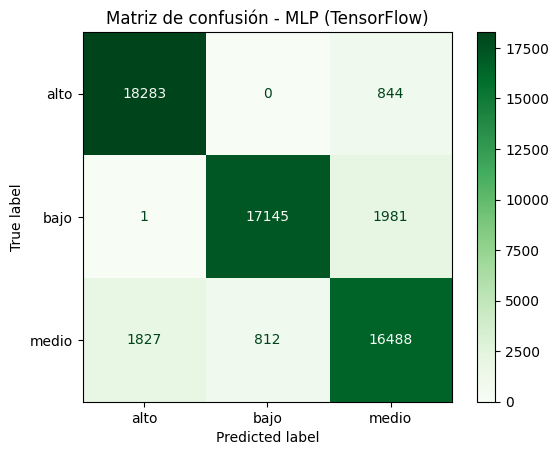

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=C:\Users\roger\OneDrive\Desktop\Tesis_MIA\mlp_tf_model.

In [1]:
# Script MLP con GPU (TensorFlow) y progreso por época
# Asegúrate de tener instalado: tensorflow, scikit-learn, pandas, matplotlib
#   pip install tensorflow scikit-learn pandas matplotlib joblib

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Ruta al archivo CSV en tu máquina local (Windows)
csv_path = r"C:\Users\roger\OneDrive\Desktop\Tesis_MIA\Datos_hospitalarios.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el archivo en {csv_path}. Comprueba que la ruta sea correcta.")

# Cargar datos
dates = ['fecha_nacimiento', 'fecha_inicio_vigencia', 'fecha_termino_vigencia']
df = pd.read_csv(csv_path, parse_dates=dates)
df.set_index('rut_asegurado_anonimizado', inplace=True)

# Crear variable objetivo y codificar etiquetas
df['risk'] = pd.qcut(df['suma_costo_directo'], q=3, labels=['bajo','medio','alto'])
le = LabelEncoder()
df['risk_enc'] = le.fit_transform(df['risk'])  # bajo→0, medio→1, alto→2

top_n = 20
top_cats = df['glosa_diagnostico'].value_counts().nlargest(top_n).index
df['glosa_red'] = df['glosa_diagnostico'].where(df['glosa_diagnostico'].isin(top_cats), other='otros')

# Definir features y target
features = ['sexo','glosa_red','edad_al_hospitalizarse',
            'plan_para_asegurados','plan_catastrofico_asegurado',
            'estado_vigencia_cobertura','prestacion_basica','cto_dto']
X = df[features]
y = df['risk_enc']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocesamiento: one-hot + escala numéricas
target_cats = ['sexo','glosa_red','plan_para_asegurados',
               'plan_catastrofico_asegurado','estado_vigencia_cobertura','prestacion_basica']
numeric = ['edad_al_hospitalizarse','cto_dto']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), target_cats)
], remainder='passthrough')

# Ajustar y transformar
tX_train = preprocessor.fit_transform(X_train)
tX_test = preprocessor.transform(X_test)

# Escalar todas las características
scaler = StandardScaler()
tX_train = scaler.fit_transform(tX_train)
tX_test = scaler.transform(tX_test)

# Definir modelo MLP en TensorFlow para GPU
dim_input = tX_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(dim_input,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen de GPU disponible
devices = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", devices)

# Entrenamiento con verbose=1 para ver progreso por época
history = model.fit(
    tX_train, y_train,
    validation_data=(tX_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluación en test
test_loss, test_acc = model.evaluate(tX_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Predicciones y métricas
y_prob = model.predict(tX_test)
y_pred = np.argmax(y_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=le.classes_, cmap='Greens'
)
plt.title('Matriz de confusión - MLP (TensorFlow)')
plt.show()

# Guardar el modelo y pipeline
base_dir = os.path.dirname(csv_path)
model.save(os.path.join(base_dir, 'mlp_tf_model'))
import joblib as jl
jl.dump({'preprocessor': preprocessor, 'scaler': scaler, 'label_encoder': le}, 
        os.path.join(base_dir, 'mlp_tf_pipeline.pkl'))
print("Modelo y pipeline guardados en", base_dir)
